In [15]:
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# %load ../kiwi/dataloader.py
import numpy as np
import cv2
import os
import imghdr

ROOT_PATH = os.path.abspath('../')

def prepare_image(fullpath):
  """ Resize the image, convert it to gray scale and flatten the array """
  image = cv2.imread(fullpath)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  return cv2.resize(gray, (28, 28)).flatten()

def from_folder(target_folder):
  """ Transform the data into an input/output format suitable for model training
  Images are loaded as arrays """
  data_dir = os.path.join(ROOT_PATH, target_folder)
  classes = [c for c in os.listdir(data_dir)
               if os.path.isdir(os.path.join(data_dir, c))]

  print("Grabbing files for %s classes..." % len(classes))
  X_data = []
  Y_data = []
  for class_id in classes:
    class_folder = os.path.join(data_dir, class_id)
    for file in os.listdir(class_folder):
      if os.path.basename(os.path.join(class_folder, file)): # images only
        image_path = os.path.join(ROOT_PATH, data_dir, class_id, file)
        X_data.append(prepare_image(image_path))
        Y_data.append(int(class_id))

  return np.array(X_data), np.array(Y_data)

def from_infer_folder(target_folder):
  """ Transform the data into a format suitable for model prediction """
  X_data = []
  files = []
  data_dir = os.path.join(ROOT_PATH, target_folder)
  print("Loading images from", data_dir)
  for file in os.listdir(data_dir):
    image_path = os.path.join(ROOT_PATH, data_dir, file)
    if os.path.basename(image_path) and imghdr.what(image_path):
      X_data.append(prepare_image(image_path))
      files.append(image_path)
  
  print("Found %s file(s)" % len(X_data))
  return np.array(X_data), files

In [4]:
X_data, Y_data = from_folder('images/train')
X_test, Y_test = from_folder('images/test')
print('X: %s, Y: %s' % (X_data.shape, Y_data.shape))
print('Xt: %s, Yt: %s' % (X_test.shape, Y_test.shape))

Grabbing files for 43 classes...
Grabbing files for 43 classes...
X: (954, 784), Y: (954,)
Xt: (259, 784), Yt: (259,)


In [8]:
# One-hot vector
################

classes = np.array(range(0,43))
y_enc = LabelEncoder().fit_transform(classes)
lblbin = LabelBinarizer().fit(y_enc)

Y_data_bin = lblbin.transform(Y_data)
Y_test_bin = lblbin.transform(Y_test)
Y_data_bin.shape

(954, 43)

# Model training

In [9]:
# Graph Definition
##################

LEARNING_RATE = 0.5 #1e-4
NUM_EPOCHS = 1000

samples, features = X_data.shape
classes_length = classes.shape[0]

tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, features])
y_ = tf.placeholder(tf.int32, [None, classes_length])

W = tf.Variable(tf.zeros([features, classes_length]))
b = tf.Variable(tf.zeros([classes_length]))
# Y = Wx + b with softmax activiation function
# y = tf.nn.softmax(tf.add(tf.matmul(x, W), b))
y = tf.add(tf.matmul(x, W), b)

# cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
# train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

# cost = tf.losses.sparse_softmax_cross_entropy(labels=y_, logits=y)
cost = tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=LEARNING_RATE).minimize(cost)

In [29]:
# Training
##########

saver = tf.train.Saver()
model_target_path = os.path.join(ROOT_PATH, 'models/model2/saved/logittf')

correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

loss_trace = []
train_acc = []
test_acc = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print('Fitting the model...')
    for epoch in range(NUM_EPOCHS):
        cost_in_each_epoch = 0

        _, c = sess.run([optimizer, cost], feed_dict={x: X_data, y_: Y_data_bin})
        cost_in_each_epoch += c
        
        # plot data
        loss_trace.append(c)
        train_acc.append(accuracy.eval({x: X_data, y_: Y_data_bin}))
        test_acc.append(accuracy.eval({x: X_test, y_: Y_test_bin}))

        if (epoch+1) % 100 == 0:
            print("Epoch {}:".format(epoch + 1), "cost={}".format(cost_in_each_epoch.max()))

    # Model persistence
    save_path = saver.save(sess, model_target_path)
    print("Model saved in path: %s" % save_path)

    # Evaluation
    print("\nTraining-set accuracy:", accuracy.eval({x: X_data, y_: Y_data_bin}))
    print("Test-set accuracy:", accuracy.eval({x: X_test, y_: Y_test_bin}))

Fitting the model...
Epoch 100: cost=1322939264.0
Epoch 200: cost=326918944.0
Epoch 300: cost=17218750.0
Epoch 400: cost=7253771.0
Epoch 500: cost=4667388.0
Epoch 600: cost=6332665.5
Epoch 700: cost=1625696.0
Epoch 800: cost=1800589.5
Epoch 900: cost=0.0
Epoch 1000: cost=0.0
Model saved in path: /Users/orendon/dev/ml/German-Traffic-Signs-Detector/models/model2/saved/logittf

Training-set accuracy: 1.0
Test-set accuracy: 0.71428573


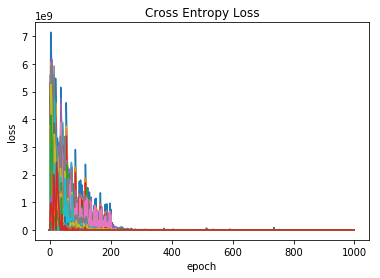

In [30]:
plt.plot(loss_trace)
plt.title('Cross Entropy Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

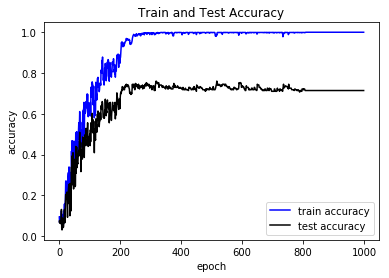

In [22]:
plt.plot(train_acc, 'b-', label='train accuracy')
plt.plot(test_acc, 'k-', label='test accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Train and Test Accuracy')
plt.legend(loc='best')
plt.show()

# Predicting from saved model

In [11]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, features])
y_ = tf.placeholder(tf.int32, [None, classes_length])

W = tf.Variable(tf.zeros([features, classes_length]))
b = tf.Variable(tf.zeros([classes_length]))
y = tf.add(tf.matmul(x, W), b)

cost = tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=LEARNING_RATE).minimize(cost)

saver = tf.train.Saver()
X_user, files = from_infer_folder('images/user')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, model_target_path)
    
    prediction=tf.argmax(y, 1)
    result = prediction.eval(feed_dict={x: X_user}, session=sess)
    
    print('\nPredicted classes', result)

Loading images from /Users/orendon/dev/ml/German-Traffic-Signs-Detector/images/user
Found 2 file(s)
INFO:tensorflow:Restoring parameters from /Users/orendon/dev/ml/German-Traffic-Signs-Detector/models/model2/saved/logittf

Predicted classes [25  1]
